# Projeto de Análise de Dados
### Desenvolvido por [Ian Rodrigues dos Reis Paixão]

Este notebook foi criado por **[Ian Rodrigues dos Reis Paixão]**, com o objetivo de analisar as reviews de produtos comprados buscando info como palavras mais frequentes, frequencia dos reviews etc.   
**Data de Criação:** [07/11/2024]  
**Contato:** [iang.master100@gmail.com]  

# Libs & Dataset

In [ ]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import string
import nltk
from nltk.corpus import stopwords
import torch
from textblob import TextBlob
from datetime import datetime
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from transformers import pipeline, AutoTokenizer
from torch.utils.data import DataLoader
from tqdm import tqdm
from nltk.stem import WordNetLemmatizer
from collections import Counter
from unidecode import unidecode

sns.set()

In [ ]:
df = pd.read_csv('private_company_product_review_dataset.csv')
# Removendo coluna de indices que apareceu ao ler o dataset
df = df.loc[:, ~df.columns.str.match('Unnamed')]

In [ ]:
df.head()

,review_id,review_datetime,product_id,product_name,product_brand_name,product_category_l1,product_category_l2,review_comment_title,review_comment_text,review_rate,review_recommend_to_a_friend,reviewer_id,reviewer_birth_year,reviewer_gender,reviewer_brazilian_state
0,00003a66-56db-4974-a70c-54506b7900e3,2021-05-10T10:00:01Z,113784,Kit 3 Em 1 Descascador Cortador Modelador Frut...,NaN,Beleza e Perfumaria,Cabelo,Gostei muito do produto .,Entrega super rápida . Parabéns pela agilida...,5,Yes,6c3872c4-031f-40b3-a652-8566b36b01d4,1952.0,M,Rio de Janeiro
1,00005dc4-7f7c-42bb-93bb-9c22981c1288,2021-04-20T05:57:09Z,101682,Relógio Casio G-Shock Masculino DW-9052GBX-1A9DR,NaN,Relógios,Relógios de Pulso,Não entregue,O produto não foi entregue e após um mês da co...,1,No,b9f99932-a41f-47f3-b002-4546e07b35dd,1992.0,F,Paraná
2,000120f1-1b5d-4c4b-b082-9299c092d648,2021-05-14T17:08:03Z,116516,Relógio Casio Feminino Ltp-V002gl-9budf,NaN,Relógios,Relógios,O Relógio não funciona,A minha esposa foi acerta o relógio e não func...,1,No,9f6d9901-fb0f-4aeb-a068-a0888cb1f724,1956.0,M,Distrito Federal
3,0001485c-6f78-4688-96dd-2f068a1c5a00,2021-04-15T20:17:49Z,68726,Liquidificador Individual Azul Hamilton Beach,NaN,Eletroportáteis,Chaleira Elétrica,Muito bom!,Supriu as expectativas! ótimo para viagens!! e...,4,Yes,f519125b-d6c5-4759-9e6f-0c3eb7030045,1976.0,M,São Paulo
4,00018688-a91b-430f-8aa2-815c40c8faed,2021-05-04T09:49:04Z,48926,Game God Of War - PS4,NaN,Games,Playstation 4,God of war,Pre venda aqui nunca mais ridiculo.Ainda estao...,2,Yes,2ea57913-3db0-47ff-99c5-8234dad569f9,1991.0,M,São Paulo


In [ ]:
df.describe()

,product_id,review_rate,reviewer_birth_year
count,142400.000000,142400.000000,136419.000000
mean,60537.337121,3.531264,1977.609930
std,32626.372638,1.530470,21.405264
min,28310.000000,1.000000,59.000000
25%,31764.000000,2.000000,1969.000000
50%,48017.000000,4.000000,1980.000000
75%,84426.000000,5.000000,1987.000000
max,130420.000000,5.000000,2018.000000


Acima conseguimos identificar que em alguns casos o reviewer_birth_year é um valor impossível (ex: 59), valor impossivel, então é necessário tratar. (será tratado no Data Preprocessing)

# Data Preprocessing

## Missing Data

In [ ]:
# Procurando por valores nulos
missing_data = df.isnull().sum()

# Mostrando a quantidade de valores nulos por coluna
missing_data = missing_data[missing_data > 0]  # Filtro para mostrar apenas colunas com valores nulos
missing_data

product_name                     10193
product_brand_name              101442
product_category_l1                337
product_category_l2              14116
review_comment_title               302
review_comment_text               4850
review_recommend_to_a_friend        18
reviewer_birth_year               5981
reviewer_gender                   4135
reviewer_brazilian_state          3990
dtype: int64

## Dealing with missing data & wrong data

In [ ]:
# Lidando com dados nulos e dados impossíveis de acontecer

# Lidando com os dados nulos e os transformando em unknown no momento
df.fillna({
    'product_name': 'Unknown',
    'product_category_l1': 'Unknown',
    'product_category_l2': 'Unknown',
    'review_recommend_to_a_friend': 'Unknown',
    'reviewer_gender': 'Unknown',
    'reviewer_brazilian_state': 'Unknown'
}, inplace=True)

# Os dados de ano de nascimento, como são numéricos e podem ser importantes, foi optado por uma abordagem de modificalos pela mediana da coluna inteira.
# Fator que geralmente auxilia nos modelos de predição que serão usados mais a frente
median_value = df[(df['reviewer_birth_year'] != -1) & (df['reviewer_birth_year'].notna())]['reviewer_birth_year'].median()
df['reviewer_birth_year'] = df['reviewer_birth_year'].replace(-1, median_value)
df['reviewer_birth_year'] = df['reviewer_birth_year'].fillna(median_value)

# Removendo a coluna product_brand_name pois ela possui mais dados faltantes do que dados atuais
df = df.drop(columns=['product_brand_name'])

# Removendo casos do dataset onde não existe titulo nem texto do review
df = df.dropna(subset=['review_comment_text'])
df = df.dropna(subset=['review_comment_title'])


# Verificando se todos os dados nulos foram removidos
missing_data_after_fill = df.isnull().sum()
missing_data_after_fill

review_id                       0
review_datetime                 0
product_id                      0
product_name                    0
product_category_l1             0
product_category_l2             0
review_comment_title            0
review_comment_text             0
review_rate                     0
review_recommend_to_a_friend    0
reviewer_id                     0
reviewer_birth_year             0
reviewer_gender                 0
reviewer_brazilian_state        0
dtype: int64

In [ ]:
df.columns

Index(['review_id', 'review_datetime', 'product_id', 'product_name',
       'product_category_l1', 'product_category_l2', 'review_comment_title',
       'review_comment_text', 'review_rate', 'review_recommend_to_a_friend',
       'reviewer_id', 'reviewer_birth_year', 'reviewer_gender',
       'reviewer_brazilian_state'],
      dtype='object')

## Creating reviewer age with information on reviewer birth year

In [ ]:
# Aqui estamos criando uma nova coluna com informação da idade do reviewer, para usá-la ao invés do ano de nascimento do reviewer. E olharemos se
# as idades são válidas. Se não forem válidas (de 0 a 120 anos), transformaremos em -1 e posteriormente, na mediana das idades

current_year = datetime.now().year
df['reviewer_birth_year'] = pd.to_numeric(df['reviewer_birth_year'], errors='coerce')
df['reviewer_age'] = current_year - df['reviewer_birth_year']
df['reviewer_age'] = df['reviewer_age'].apply(lambda x: x if x > 0 and x < 120 else None)
df['reviewer_birth_year'] = df['reviewer_birth_year'].fillna(-1).astype(int)
df['reviewer_age'] = df['reviewer_age'].fillna(-1).astype(int)
median_value = df[(df['reviewer_age'] != -1) & (df['reviewer_age'].notna())]['reviewer_age'].median()
df['reviewer_age'] = df['reviewer_age'].replace(-1, median_value)

# Display the first few rows to verify the new 'reviewer_age' column
df[['reviewer_birth_year', 'reviewer_age']].head()

,reviewer_birth_year,reviewer_age
0,1952,72
1,1992,32
2,1956,68
3,1976,48
4,1991,33


# Exploratory Data Analysis (EDA)

## Outliers

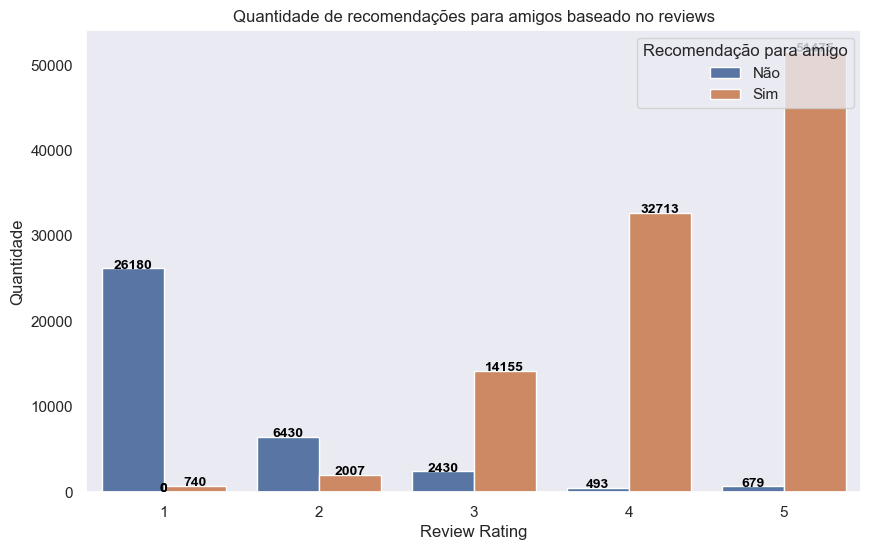

In [ ]:
# Count plot to visualize the number of recommendations based on ratings

plt.figure(figsize=(10, 6))
count_plot = sns.countplot(x='review_rate', hue='review_recommend_to_a_friend', data=df.loc[df['review_recommend_to_a_friend'].isin(['Yes','No'])])
plt.title('Quantidade de recomendações para amigos baseado no reviews')
plt.xlabel('Review Rating')
plt.ylabel('Quantidade')
plt.legend(title='Recomendação para amigo', loc='upper right', labels=['Não', 'Sim'])
plt.grid(axis='y')

# Display the count value on top of each bar
for p in count_plot.patches:
    count_plot.annotate(f'{int(p.get_height())}',
                        (p.get_x() + p.get_width() / 2., p.get_height()),
                        ha='center', va='baseline',
                        color='black', fontsize=10, weight='bold')

plt.savefig('outlier.png')
plt.show()


In [ ]:
# Removendo as colunas onde o review é 1 e é recomendado
df = df[~((df['review_rate'] == 1) & (df['review_recommend_to_a_friend'] == 'Yes'))]

# Removendo as colunas onde o review é 5 e não é recomendado
df = df[~((df['review_rate'] == 5) & (df['review_recommend_to_a_friend'] == 'No'))]

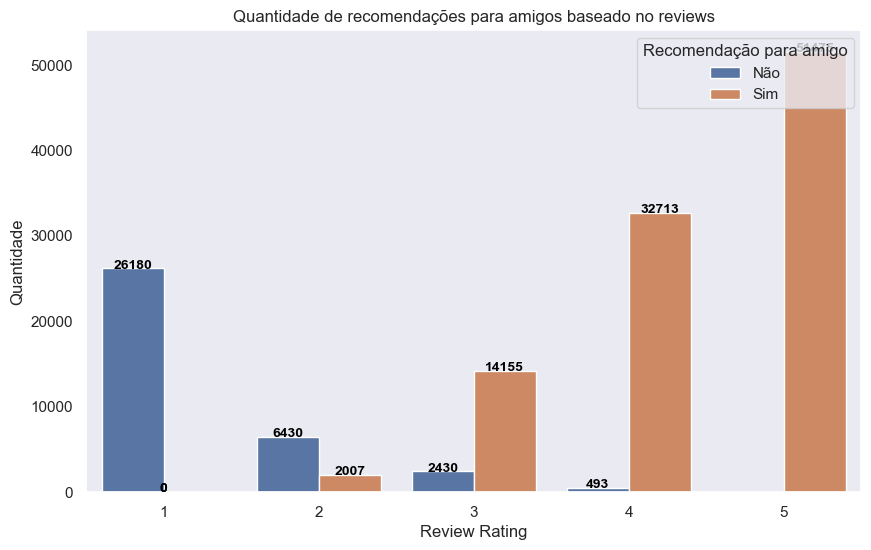

In [ ]:
# Repetindo para verificar se foi removido os outliers

plt.figure(figsize=(10, 6))
count_plot = sns.countplot(x='review_rate', hue='review_recommend_to_a_friend', data=df.loc[df['review_recommend_to_a_friend'].isin(['Yes','No'])])
plt.title('Quantidade de recomendações para amigos baseado no reviews')
plt.xlabel('Review Rating')
plt.ylabel('Quantidade')
plt.legend(title='Recomendação para amigo', loc='upper right', labels=['Não', 'Sim'])
plt.grid(axis='y')

# Display the count value on top of each bar
for p in count_plot.patches:
    count_plot.annotate(f'{int(p.get_height())}',
                        (p.get_x() + p.get_width() / 2., p.get_height()),
                        ha='center', va='baseline',
                        color='black', fontsize=10, weight='bold')

plt.savefig('outlier_2.png')
plt.show()

## Distribution of the reviews

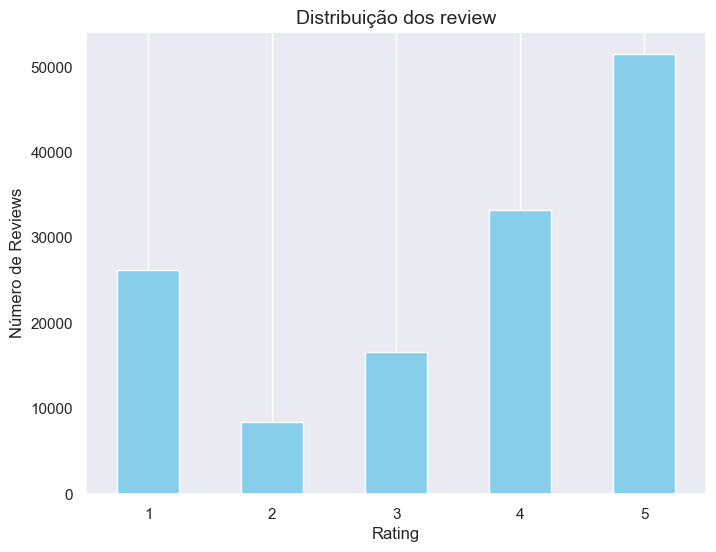

In [ ]:
# Plot the distribution of review ratings
plt.figure(figsize=(8, 6))
df['review_rate'].value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.title('Distribuição dos review', fontsize=14)
plt.xlabel('Rating', fontsize=12)
plt.ylabel('Número de Reviews', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.savefig('distribution.png')

# Show the plot
plt.show()

## Avg Rating & Num reviews by product name

In [ ]:
# Agrupando por product_id e product_name para calcular a média das avaliações e o número de avaliações por produto
top_rated_products = df.groupby(['product_id', 'product_name']).agg(
    avg_rating=('review_rate', 'mean'),
    num_reviews=('review_rate', 'count')
).sort_values(by='avg_rating', ascending=False)

# Exibir os 10 produtos mais bem avaliados com base na média das avaliações.
top_rated_products = top_rated_products[top_rated_products['num_reviews'] > 10]
top_rated_products.head(10)

,,avg_rating,num_reviews
product_id,product_name,,
41862,Mouse Gamer G403 Prodigy 12.000 DPI PC - Logitech,5.000000,11
33854,"iPhone 8 Dourado 256GB Tela 4.7"" IOS 11 4G Wi-Fi câmera 12MP - Apple",5.000000,12
32580,Game - The Witcher III Wild Hunt: Edição Completa - Xbox One,4.961538,26
44786,Fraldas Descartáveis Huggies Primeiros 100 dias P - 54 Unidades,4.952381,63
71622,Copo De Vidro Americano 450ml - Nadir,4.937500,16
81610,Smartphone Asus Zenfone 4 Max Dual Chip Android 7 Tela 5.5 32GB 4G Dual Cam 13+5 MP - Preto + Bastão,4.928571,14
29056,"iPhone 8 Plus Dourado 64GB Tela 5.5"" IOS 11 4G Wi-Fi Câmera 12MP - Apple",4.913043,23
38928,Game - The Last Of Us Remasterizado - PS4,4.909091,11
112876,Chave Para Tubos Cube 24 - Tramontina Pro,4.869565,23


## Avg Rating and Num of reviews per Gender

In [ ]:
# Agrupando por gênero do revisor para calcular a média das avaliações e o número de avaliações por gênero.
gender_analysis = df.groupby('reviewer_gender').agg(
    avg_rating=('review_rate', 'mean'),
    num_reviews=('review_rate', 'count')
).sort_values(by='num_reviews', ascending=False)

# Exibir os resultados da análise de gênero.
gender_analysis

,avg_rating,num_reviews
reviewer_gender,,
M,3.522537,67867
F,3.578898,64127
Unknown,3.717942,3907


## Number of reviews Over Time

C:\Users\Gabriel\AppData\Local\Temp\ipykernel_42400\2823754963.py:6: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df_trend['review_year_month'] = df['review_datetime'].dt.to_period('M')


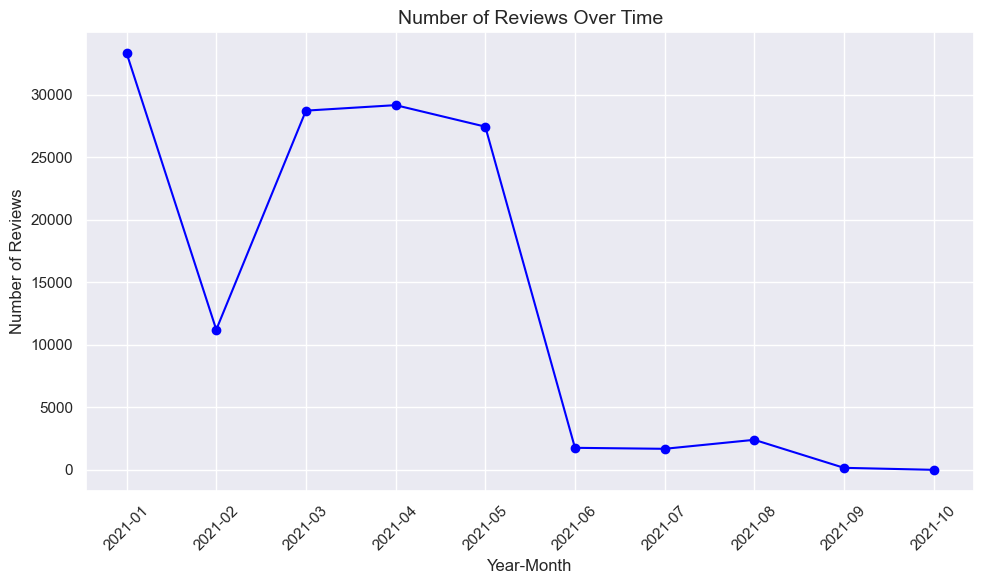

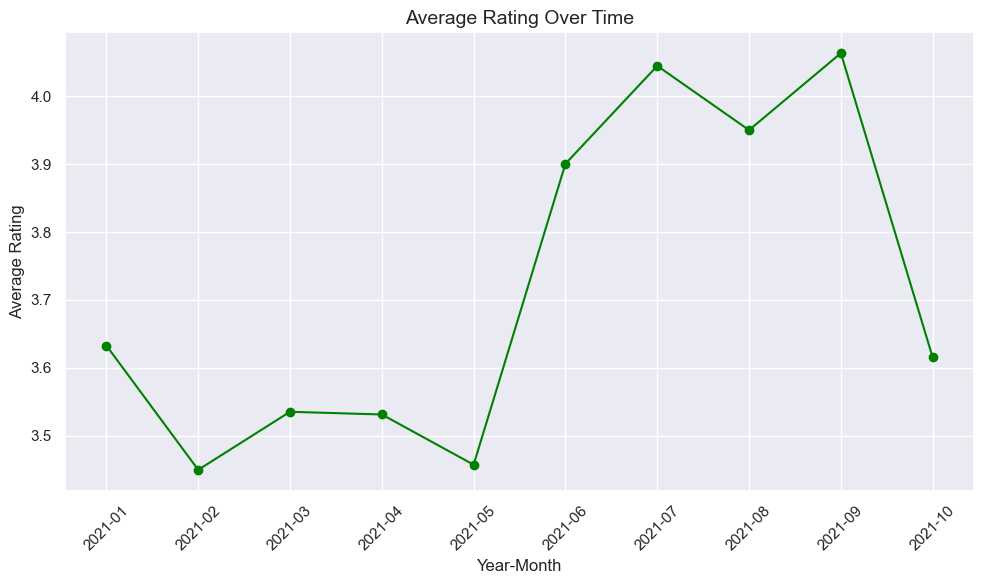

In [ ]:
# Convertendo o 'review_datetime' para o formato de data e hora adequado
df_trend = df
df_trend['review_datetime'] = pd.to_datetime(df['review_datetime'])

# Extraindo o ano e o mês do review_datetime para análise de séries temporais.
df_trend['review_year_month'] = df['review_datetime'].dt.to_period('M')

# Agrupando por ano-mês para calcular o número de avaliações e a média das avaliações por mês.
time_series_trends = df_trend.groupby('review_year_month').agg(
    num_reviews=('review_rate', 'count'),
    avg_rating=('review_rate', 'mean')
).reset_index()

# Plot das tendências do número de avaliações ao longo do tempo.
plt.figure(figsize=(10, 6))
plt.plot(time_series_trends['review_year_month'].astype(str), time_series_trends['num_reviews'], marker='o', linestyle='-', color='blue')
plt.xticks(rotation=45)
plt.title('Number of Reviews Over Time', fontsize=14)
plt.xlabel('Year-Month', fontsize=12)
plt.ylabel('Number of Reviews', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.savefig('reivews_time.png')
plt.show()

# Plot das tendências da média das avaliações ao longo do tempo.
plt.figure(figsize=(10, 6))
plt.plot(time_series_trends['review_year_month'].astype(str), time_series_trends['avg_rating'], marker='o', linestyle='-', color='green')
plt.xticks(rotation=45)
plt.title('Average Rating Over Time', fontsize=14)
plt.xlabel('Year-Month', fontsize=12)
plt.ylabel('Average Rating', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.savefig('avgRate_time.png')
plt.show()

# Number of reviews over time by state

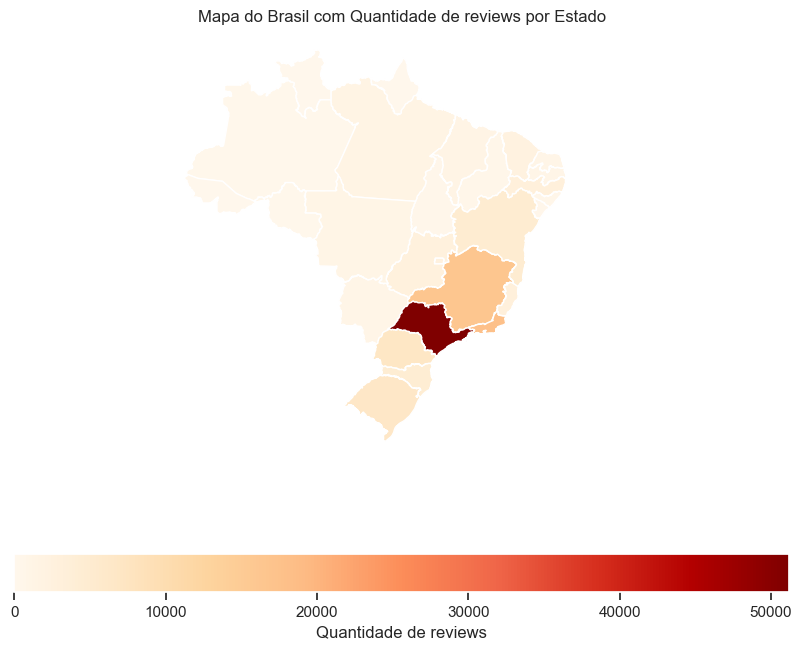

In [ ]:
# Carregando o arquivo shapefile do mapa do Brasil. disponivel em: https://geoftp.ibge.gov.br/cartas_e_mapas/bases_cartograficas_continuas/bcim/versao2016/geopackage/
mapa = gpd.read_file('bcim_2016_21_11_2018.gpkg', layer = 'lim_unidade_federacao_a')
mapa = mapa.rename(columns={'nome': 'reviewer_brazilian_state'})

# Agregando a contagem de avaliações por estado para o ano-mês mais recente.
state_review_counts = df.groupby('reviewer_brazilian_state').size().reset_index(name='num_reviews')
map = mapa.merge(state_review_counts, on='reviewer_brazilian_state', how='left')
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
map.plot(column='num_reviews', ax=ax, legend=True,
               cmap='OrRd', legend_kwds={'label': "Quantidade de reviews",
                                         'orientation': "horizontal"},
         vmin=0, vmax=map['num_reviews'].max())
ax.set_axis_off()
plt.title('Mapa do Brasil com Quantidade de reviews por Estado')
plt.savefig('reviews_state.png')
plt.show()

In [ ]:
state_review_counts.sort_values(by=['num_reviews'],ascending=False).head()

,reviewer_brazilian_state,num_reviews
25,São Paulo,51213
20,Rio de Janeiro,17940
12,Minas Gerais,16603
13,Paraná,6899
19,Rio Grande do Sul,6743


# Mean of review_rate over time by state

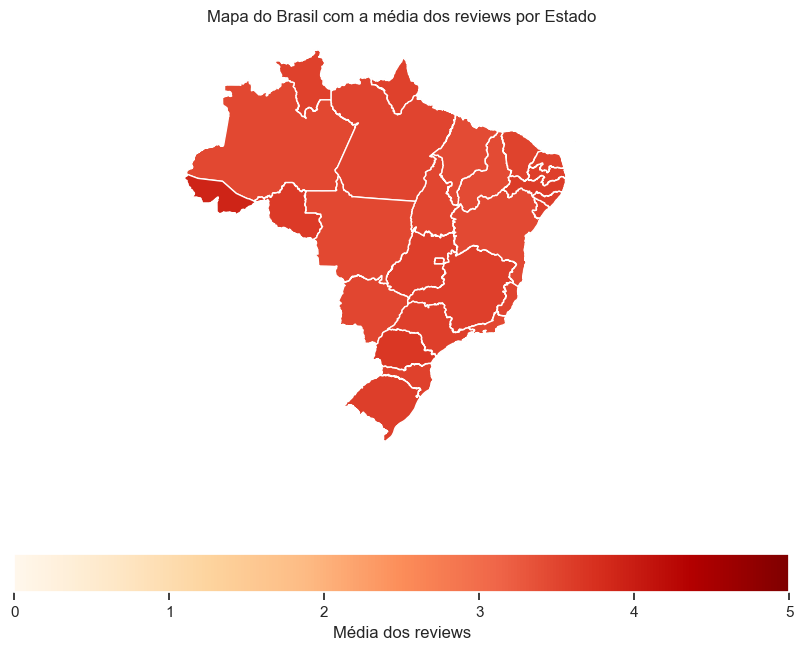

In [ ]:
mean_rates = df.groupby('reviewer_brazilian_state')['review_rate'].mean().reset_index()
map = mapa.merge(mean_rates, on='reviewer_brazilian_state', how='left')

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
map.plot(column='review_rate', ax=ax, legend=True,
               cmap='OrRd', legend_kwds={'label': "Média dos reviews",
                                         'orientation': "horizontal"},
         vmin=0, vmax=5)
ax.set_axis_off()
plt.title('Mapa do Brasil com a média dos reviews por Estado')
plt.savefig('avgRate_state.png')
plt.show()

In [ ]:
mean_rates.sort_values(by=['review_rate'],ascending=False).head()

,reviewer_brazilian_state,review_rate
0,Acre,3.901235
27,Unknown,3.733528
13,Paraná,3.663719
21,Rondônia,3.613982
16,Pernambuco,3.600864


## Number of reviews and average rating per reviewer

In [ ]:
# Agrupando por reviewer_id para calcular o número de avaliações e a média das avaliações por revisor.
reviewer_loyalty = df.groupby('reviewer_id').agg(
    num_reviews=('review_rate', 'count'),
    avg_rating=('review_rate', 'mean')
).sort_values(by='num_reviews', ascending=False)

# Top 10 reviewers mais ativos
reviewer_loyalty.head(10)

,num_reviews,avg_rating
reviewer_id,,
6c3872c4-031f-40b3-a652-8566b36b01d4,154,5.000000
c60b2f78-4a22-4fbf-a694-e1b8a8fcc837,75,5.000000
b2076118-b6bf-40fd-8f3b-6bfa6457b2e0,64,3.250000
03c869e4-8f07-4bd0-8a02-fc25149cf692,57,1.228070
229242e8-ffa2-4a24-b25c-53f6af133764,41,1.878049
3338a9e2-419f-43fa-b91a-4ff05706b345,41,1.000000
1602b55a-6544-4896-b9c7-122ab9a84a63,38,5.000000
dea7f574-c335-4329-a130-c03339fbb222,36,5.000000
392d54a1-292c-494d-9421-0140b331d016,29,4.517241


# Sentiment Analysis

## Removing stopwords, punctuation, numbers, and special characters; Converting to lowercase and Tokenizing

In [ ]:
# Download NLTK stopwords
nltk.download('stopwords')

# Definindo stopwords em português
stop_words = set(stopwords.words('portuguese'))

# Função de pré-processamento de texto
def preprocess_text(text):
    # Converte para lowercase
    text = text.lower()

    # Remove acentuações
    text = unidecode(text)

    # Remove pontuação e números
    text = ''.join([char for char in text if char not in string.punctuation and not char.isdigit()])

    # Tokeniza o texto
    words = text.split()

    # Remove stopwords
    cleaned_words = [word for word in words if word not in stop_words]

    # Voltando a ser uma string
    return ' '.join(cleaned_words)

# Aplicando o pré-processamento de texto no comentário do review e no título
df['cleaned_review_text'] = df['review_comment_text'].apply(preprocess_text)
df['cleaned_review_title'] = df['review_comment_title'].apply(preprocess_text)

# Exibindo o resultado
df[['review_comment_text', 'cleaned_review_text']].head()


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Gabriel\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,review_comment_text,cleaned_review_text
0,Entrega super rápida . Parabéns pela agilida...,entrega super rapida parabens agilidade entreg...
1,O produto não foi entregue e após um mês da co...,produto nao entregue apos mes compra tentando ...
2,A minha esposa foi acerta o relógio e não func...,esposa acerta relogio nao funcionou abri ver b...
3,Supriu as expectativas! ótimo para viagens!! e...,supriu expectativas otimo viagens facil lavar ...
4,Pre venda aqui nunca mais ridiculo.Ainda estao...,pre venda aqui nunca ridiculoainda estao dentr...


## Evaluating top words of reviewers by month

In [ ]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter

# Ensure necessary resources are downloaded
nltk.download('punkt')
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()

# Function to clean and lemmatize the text
def preprocess_text(text):
    # Tokenize the text
    tokens = word_tokenize(text, language='portuguese')
    # Lemmatize and remove stop words
    lemmatized_tokens = [lemmatizer.lemmatize(token.lower()) for token in tokens if token.isalpha() and token.lower() not in stop_words]
    return lemmatized_tokens

# Apply the preprocessing to the cleaned_review_text column
df['lemmatized_text'] = df['cleaned_review_text'].apply(preprocess_text)

# Explode the lemmatized words into separate rows for counting
df_exploded = df.explode('lemmatized_text')

# Group by month and lemmatized word, then count occurrences
top_words_by_month = df_exploded.groupby(['review_year_month', 'lemmatized_text']).size().reset_index(name='count')

# Get top 5 words for each month
top_words = top_words_by_month.sort_values(['review_year_month', 'count'], ascending=[True, False]).groupby('review_year_month').head(5)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Gabriel\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Gabriel\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


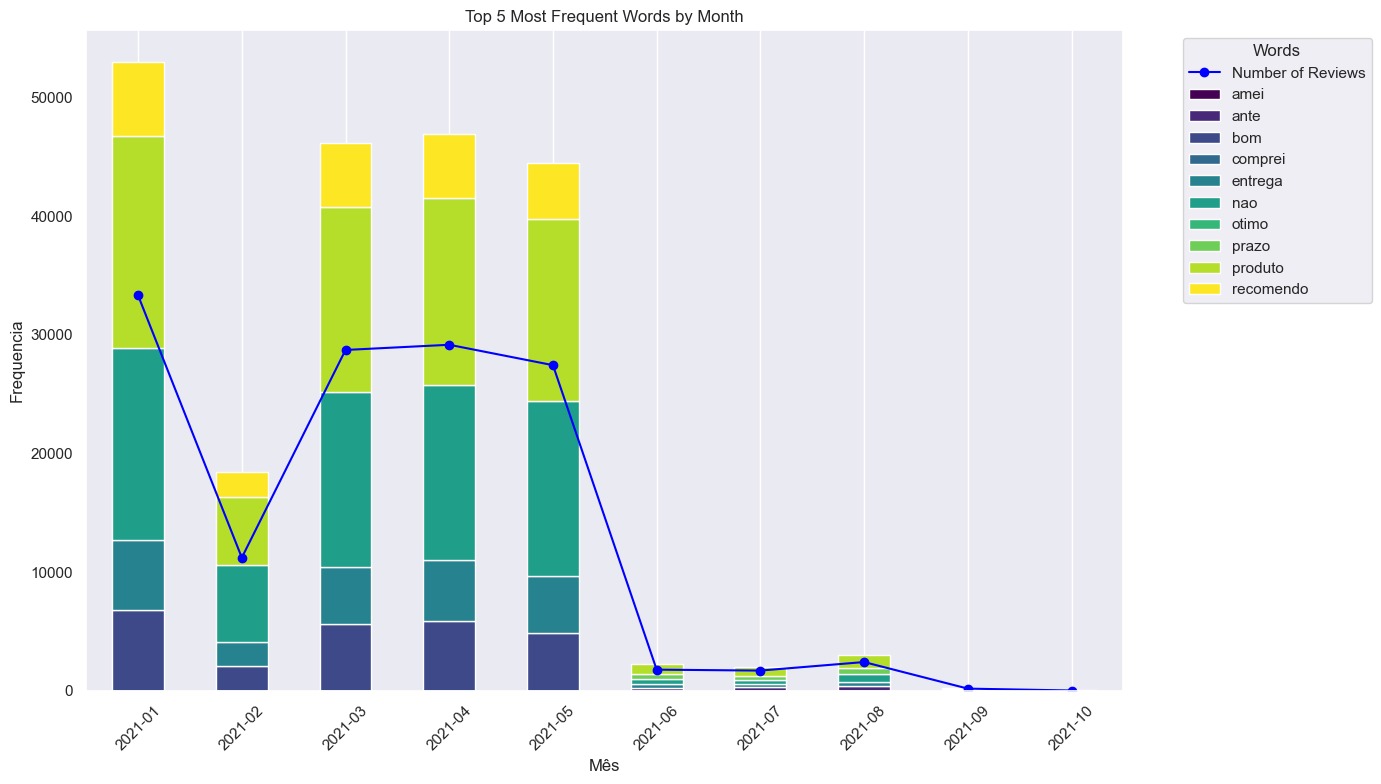

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare the data for plotting
top_words['lemmatized_text'] = top_words['lemmatized_text'].astype(str)  # Ensure correct data type for plotting

# Create a pivot table to structure data for plotting
pivot_table = top_words.pivot(index='review_year_month', columns='lemmatized_text', values='count').fillna(0)

# Plotting the top words by month
plt.figure(figsize=(14, 8))
pivot_table.plot(kind='bar', stacked=True, colormap='viridis', ax=plt.gca())
plt.plot(time_series_trends['review_year_month'].astype(str), time_series_trends['num_reviews'], marker='o', linestyle='-', color='blue', label='Number of Reviews')
plt.title('Top 5 Most Frequent Words by Month')
plt.xlabel('Mês')
plt.ylabel('Frequencia')
plt.xticks(rotation=45)
plt.legend(title='Words', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y')
plt.tight_layout()  # Adjust layout to make room for the legend
plt.savefig('freq_words.png')
plt.show()


## Text Blob

In [ ]:
# Aplicando textBlob no texto limpo
df['textblob_sentiment'] = df['cleaned_review_text'].apply(lambda text: TextBlob(text).sentiment.polarity)
df[['cleaned_review_text', 'textblob_sentiment', 'review_rate']].head()

,cleaned_review_text,textblob_sentiment,review_rate
0,entrega super rapida parabens agilidade entreg...,0.333333,5
1,produto nao entregue apos mes compra tentando ...,0.000000,1
2,esposa acerta relogio nao funcionou abri ver b...,0.000000,1
3,supriu expectativas otimo viagens facil lavar ...,0.150000,4
4,pre venda aqui nunca ridiculoainda estao dentr...,0.000000,2


## BERT

In [ ]:
from transformers import pipeline, AutoTokenizer
import pandas as pd

# Carregando o pipeline do tokenizador do BERT
model_name = "nlptown/bert-base-multilingual-uncased-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
sentiment_pipeline = pipeline("sentiment-analysis", model=model_name, device='cuda')

# Truncando o máximo de tokens aceitáveis para não exceder o do BERT
def truncate_text_token_level(text, tokenizer, max_length=512):
    tokens = tokenizer(text, truncation=True, max_length=max_length, return_tensors="pt")
    truncated_text = tokenizer.decode(tokens['input_ids'][0], skip_special_tokens=True)
    return truncated_text

# Aplicando o método de trunc nos dados textuais
df['cleaned_review_text_truncated'] = df['cleaned_review_text'].apply(lambda x: truncate_text_token_level(x, tokenizer))

# Convertendo os reviews truncados no formato de lista
truncated_reviews = df['cleaned_review_text_truncated'].tolist()

# Definindo batch size
batch_size = 32

# Criando DataLoader para processamento dos batches
dataloader = DataLoader(truncated_reviews, batch_size=batch_size)

# Processando batches usando o pipeline do nlptown
sentiment_scores = []
for batch in tqdm(dataloader, desc="Processing Sentiment Analysis"):
    batch_sentiments = sentiment_pipeline(batch)
    sentiment_scores.extend([result['score'] for result in batch_sentiments])

# Adicionando os resultados ao dataframe
df['bert_sentiment'] = sentiment_scores

# Exibindo os resultados
print(df[['cleaned_review_text_truncated', 'bert_sentiment', 'review_rate']].head())

Processing Sentiment Analysis:  20%|█▉        | 836/4247 [04:41<19:27,  2.92it/s]

# Classificador

In [ ]:
df.head()

## Promotores e Detratores

In [ ]:
# Definir a classe alvo
df['promoter_detractor'] = df['review_rate'].apply(lambda x: 'Promotor' if x >= 4 else 'Detrator' if x <= 2 else 'Neutro')

# Verificar a distribuição das classes
print(df['promoter_detractor'].value_counts())


## Remoção das features não importantes para o modelo

In [ ]:
# Remover colunas irrelevantes
df_clean = df.drop(columns=['review_id', 'review_datetime', 'review_rate', 'product_id', 'reviewer_id',
                      'review_comment_text', 'review_comment_title', 'reviewer_birth_year', 'review_year_month',
                     'cleaned_review_title', 'product_name', 'textblob_sentiment','cleaned_review_text_truncated',
                            'lemmatized_text']).reset_index(drop = True)

#df_clean = df_clean.loc[df_clean['promoter_detractor'] != 'Neutro']

In [ ]:
df_clean.head()

## TF_IDF

In [ ]:
# Inicializando a vetorização do TF_IDF
tfidf_vectorizer = TfidfVectorizer(max_features=500) #Limitando a 500 features por eficiencia de código

# Aplicando TF_IDF nos dados limpos
tfidf_matrix = tfidf_vectorizer.fit_transform(df_clean['cleaned_review_text'])

# Convertendo os resultados em uma matrix
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

In [ ]:
df_clean = df_clean.drop(columns=['cleaned_review_text'])

In [ ]:
tfidf_df.head()

## Variáveis Dummy

In [ ]:
# Vamos alterar as variáveis categóricas em variáveis do tipo dummy para melhorar a predição do nosso modelo
df_clean = pd.get_dummies(df_clean, columns=['reviewer_gender','review_recommend_to_a_friend',
                                         'product_category_l1', 'product_category_l2', 'reviewer_brazilian_state'], drop_first=True)

## Padronização dos dados

In [ ]:
# Vamos escalonar os dados numéricos para também melhorar a predição do nosso modelo
scaler_age = StandardScaler()
df_clean['reviewer_age'] = scaler_age.fit_transform(df_clean[['reviewer_age']])

## Convert true/false to 1/0

In [ ]:
df_clean.head()

In [ ]:
# Convertendo True/False para 0/1 nas variáveis booleanas
bool_columns = df_clean.select_dtypes(include=['bool']).columns
df_clean[bool_columns] = df_clean[bool_columns].astype(int)

In [ ]:
df_clean.head()

## Transformando a variável alvo como 0, 1 e 2

In [ ]:
# Mapeando reviewer Promotor como 1 e Detrator como 0 e neutro como 2
df_clean['promoter_detractor'] = df_clean['promoter_detractor'].map({'Promotor': 1, 'Detrator': 0, 'Neutro': 2})

In [ ]:
df_clean.head()

## Train Test Split

In [ ]:
# Combinando o dataset final com o dataset do TF_IDF
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
combined_df = pd.concat([tfidf_df.reset_index(drop=True), df_clean.reset_index(drop=True)], axis=1)

# Dividir as features (X) e target (y)
X = combined_df.drop(columns=['promoter_detractor'])
y = combined_df['promoter_detractor']

# Dividir em conjunto de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# Verificar o desbalanceamento inicial (Apesar que já foi mencionado que não irá haver metodo de desbalanceamento de classe)
print("Distribuição das classes no conjunto de treino:")
print(y_train.value_counts())

In [ ]:
X_train

In [ ]:
y_train

## Modelo XGBoost

In [ ]:
# Definindo o modelo XGBoost
xgb_model = xgb.XGBClassifier(
    eval_metric='mlogloss',
    tree_method='hist',
    device='cuda', # Usei GPU
    verbosity=2
)

# Otimização dos parametros
param_grid = {
    'n_estimators': [50, 100, 200],           # Número de árvores
    'max_depth': [3, 5, 7],                   # Profundidade máxima das árvores
    'learning_rate': [0.01, 0.1, 0.2],        # Taxa de aprendizado
}

# Configurando o GridSearchCV
grid_search = GridSearchCV(estimator=xgb_model,
                             param_grid=param_grid,
                             scoring='accuracy',  # f1 ou auc-roc também são bons
                             cv=3,                # Número de folds para cross-validation
                             verbose=2,
                             n_jobs=4)           # Usei 4 núcleos da minha GPU

# Treinando o modelo com GridSearch
grid_search.fit(X_train, y_train)

# Melhor combinação de parâmetros
print("Melhores parâmetros encontrados:", grid_search.best_params_)

# Fazer previsões com o melhor modelo
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Avaliação do modelo
print("Matriz de Confusão:")
print(confusion_matrix(y_test, y_pred))

print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred))

print(f"Acurácia: {accuracy_score(y_test, y_pred):.2f}")

## Check for overfitting

In [ ]:
# Olhando os resultados de cada época
results = grid_search.cv_results_
results_df = pd.DataFrame(results)

# Mostrando as informações do teste por época
scores_df = results_df[['params', 'mean_test_score', 'rank_test_score']]
scores_df.sort_values(by='rank_test_score')

In [ ]:
# Calculando score nos dados de treino
train_accuracy = grid_search.score(X_train, y_train)
# Calculando score nos dados de teste
test_accuracy = grid_search.score(X_test, y_test)

print(f"Training Accuracy: {train_accuracy:.2f}")
print(f"Test Accuracy: {test_accuracy:.2f}")

## Modelos SKLearn

In [ ]:
# Definindo um dicionário para armazenar os modelos e seus parâmetros
models = {
    "Logistic Regression": (LogisticRegression(max_iter=100, random_state=42), {
        'C': [0.01, 0.1, 1, 10],
        'solver': ['liblinear', 'saga'],
    }),
    "Random Forest": (RandomForestClassifier(random_state=42), {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
    }),
    "Gradient Boosting": (GradientBoostingClassifier(random_state=42), {
        'n_estimators': [100, 200],
        'learning_rate': [0.1, 0.2],
        'max_depth': [5, 7],
    }),
    "K-Nearest Neighbors": (KNeighborsClassifier(), {
        'n_neighbors': [3, 5, 7, 10],
        'weights': ['uniform', 'distance'],
    }),
}

# Armazenar os resultados
results = {}

# Treinando e avaliando cada modelo
for model_name, (model, params) in models.items():
    print(f"Treinando {model_name}...")
    grid_search = GridSearchCV(estimator=model,
                               param_grid=params,
                               scoring='accuracy',
                               cv = 2,
                               verbose=2,
                               n_jobs=4)
    # Ajustar e treinar o modelo
    grid_search.fit(X_train, y_train)
    # Melhor combinação de parâmetros
    print(f"Melhores parâmetros para {model_name}: {grid_search.best_params_}")

    # Avaliando o modelo no conjunto de teste
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)

    # Armazenando os resultados
    results[model_name] = {
        'best_params': grid_search.best_params_,
        'confusion_matrix': confusion_matrix(y_test, y_pred),
        'classification_report': classification_report(y_test, y_pred),
        'accuracy': accuracy_score(y_test, y_pred)
    }


In [ ]:
# Exibindo os resultados
for model_name, metrics in results.items():
    print(f"\n{model_name}:")
    print("Melhores parâmetros:", metrics['best_params'])
    print("Matriz de Confusão:\n", metrics['confusion_matrix'])
    print("Relatório de Classificação:\n", metrics['classification_report'])
    print(f"Acurácia: {metrics['accuracy']:.2f}")

# Final Analysis

## Correlation

In [ ]:
df.head()

In [ ]:
# Add review length to correlation analysis
df['review_length'] = df['review_comment_text'].apply(lambda x: len(x.split()))
correlation_matrix = df[['review_rate', 'reviewer_age', 'textblob_sentiment', 'bert_sentiment', 'review_length']].corr()

# Plot the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Enhanced Correlation Heatmap')
plt.show()


## Word Clouds

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Separate promoter and detractor comments based on review rating
promoter_reviews = df[df['review_rate'] >= 4]['cleaned_review_text']
detractor_reviews = df[df['review_rate'] <= 2]['cleaned_review_text']

# Create word clouds for promoters and detractors
promoter_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(" ".join(promoter_reviews))
detractor_wordcloud = WordCloud(width=800, height=400, background_color='black').generate(" ".join(detractor_reviews))

# Plot word clouds
plt.figure(figsize=(10, 5))

# Promoter Word Cloud
plt.subplot(1, 2, 1)
plt.imshow(promoter_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Promoter Word Cloud')

# Detractor Word Cloud
plt.subplot(1, 2, 2)
plt.imshow(detractor_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Detractor Word Cloud')

plt.show()
